In [623]:
import nilearn
import nilearn.plotting as nip
import nilearn.datasets as nid
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from options import MainParser as Parser
from src.trainers import get_trainer
from src.mni_locate import find_structure
import os
import joblib
import json
from src.models import get_model

In [624]:
args = Parser().parse_args(args=['--exp', 'final', '--load', '0'])
exp = args.exp
final = exp[:5] == 'final'
args.exp = '_'.join(filter(bool, [args.cond, exp]))
trainer = get_trainer(args, final)
trainer.test('test' if final else 'val', save_outputs=args.ind)

model_path = os.path.join(args.data_dir, 'models')

if args.cond == 'svc':
    svc_model = joblib.load(os.path.join(model_path, '_'.join(filter(bool, ['svc', exp])) + '.joblib'))

    def model(x):
        return svc_model.predict_proba(x)[:, 1]
else:
    mlp_model = get_model('MLP', args.res, args.z_dim)
    pretrain = 'pretrain' if args.cond == 'ae' else ''
    model_path_dir = os.path.join(args.data_dir, 'models', '_'.join(filter(bool, ['mlp', pretrain, exp])))
    final_epoch = json.load(open(os.path.join(model_path_dir, 'settings.json')))['training_epochs']
    model_path = os.path.join(model_path_dir, f'model_epoch{final_epoch}.pt')
    state = torch.load(model_path, map_location=torch.device(trainer.device))
    mlp_model.load_state_dict(state, strict=False)
    print('Pretrained weights in ' + model_path + ' loaded.')
    mlp_model = mlp_model.to(trainer.device)

    @torch.inference_mode()
    def model(x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        mlp_model.eval()
        return torch.sigmoid(mlp_model(x.to(trainer.device))['logits']).cpu().squeeze().numpy()

Loaded:  ../abide_fc_dataset_scale122/./models/counterfactual_vae_svc_final/model_epoch1000.pt
Version  counterfactual_vae_svc_final


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics:
Criterion: 1.6274e-02	KLD Smooth: 5.9597e+01	KLD: 3.5823e+01	MSE: 1.2757e-02	


/home/marinbenc/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [625]:
def get_counterfactual(trainer, ind, model, target_prob=None):
    [orig, prob], label, _ = trainer.get_tested_sample(ind)
    orig, prob = orig.unsqueeze(0), prob.view(1, 1)
    if target_prob is None:
        target_prob = torch.less(prob, 0.5).float()
    else:
        target_prob = torch.tensor([[target_prob]], device=trainer.device)
    counterfactual = trainer.generate_counterfactuals(orig, prob, target_prob)
    counterfactual_prob = model(counterfactual)
    fc = trainer.matrix_from_feature(trainer.res, counterfactual)
    return fc, counterfactual_prob

/home/marinbenc/miniconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:743: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

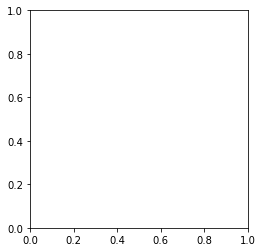

In [626]:
fig, ax = plt.subplots()
fc = get_counterfactual(trainer, 0, model)
trainer.plot_heatmap(ax, fc, title='FC')

In [627]:
atlases = nid.fetch_atlas_basc_multiscale_2015(version='sym', data_dir='../data/')
atlas = atlases['scale122']
coords = nip.find_parcellation_cut_coords(atlas)
_, structure = find_structure(coords, database_file='../TDdatabase.mat')
structure_labels = np.array(structure)[:, -1]
structure_labels = np.array([label.replace(' (aal)', '') for label in structure_labels])

In [628]:
def plot_connectome(ax, fc, title, th, **kwargs):
  ax.set_title(title)
  nip.plot_connectome(
    fc, node_coords=coords, axes=ax, title=None, 
    node_color='lightgray',
    node_size=3,
    edge_threshold=th,
    edge_cmap='Reds',
    edge_vmin=th - 0.1,
    edge_vmax=1,
    alpha=0.5,
    colorbar=True,
    **kwargs)

In [629]:
def plot_counterfactual(ind, target_p=None, save_as=None):
  [orig, prob], label, _ = trainer.get_tested_sample(ind)
  orig_fc = trainer.matrix_from_feature(trainer.res, orig)
  percentile = np.percentile(orig_fc, 98.5)

  fig, ax = plt.subplots(2, 1, figsize=(10, 10))
  ax = ax.flatten()
  fig.subplots_adjust(hspace=0.2)
  cf_fc, cf_prob = get_counterfactual(trainer, ind, model, target_p)
  plot_connectome(ax[0], orig_fc, title=f'Original, p(ASD) = {1 - prob.item():.2f}', th=percentile)
  plot_connectome(ax[1], cf_fc, title=f'Counterfactual, p(ASD) = {1 - cf_prob.item():.2f}', th=percentile)
  if save_as is not None:
    fig.savefig(save_as, bbox_inches='tight', facecolor='white', dpi=150)

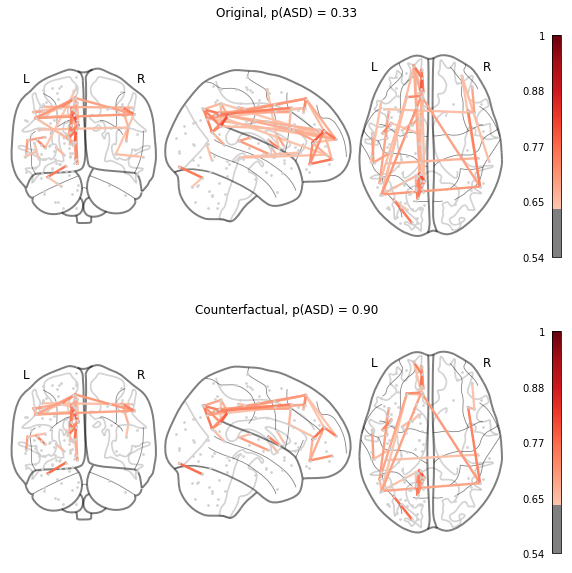

In [630]:
plot_counterfactual(4, save_as='../plots/counterfactual.png')

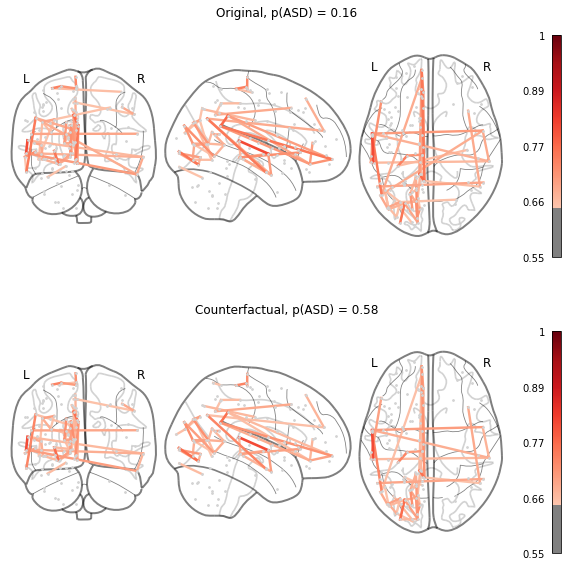

In [631]:
plot_counterfactual(5, target_p=1 - 0.6)

In [632]:
def plot_connectome_small(ax, fc, title, th, max=None, cmap=None, **kwargs):
  ax.set_title(title)
  nip.plot_connectome(
    fc, node_coords=coords, axes=ax, title=None, 
    node_color='lightgray',
    node_size=3,
    edge_threshold=th,
    edge_cmap=cmap if cmap is not None else 'Reds',
    edge_vmin=th,
    edge_vmax=1 if max is None else max,
    alpha=0.5,
    colorbar=False,
    display_mode='z',
    annotate=False,
    **kwargs)

def plot_counterfactual_small(orig, prob, ind, cf_p, ax, th, save_as=None):
  orig_fc = trainer.matrix_from_feature(trainer.res, orig)
  cf_fc, cf_prob = get_counterfactual(trainer, ind, model, target_prob=cf_p)
  plot_connectome_small(ax, cf_fc, title=f'{1 - cf_prob.item():.2f}', th=percentile)
  if save_as is not None:
    fig.savefig(save_as, bbox_inches='tight', facecolor='white', dpi=150)

In [633]:
def plot_multiple_counterfactuals(ind, save_as=None):
  [orig, prob], label, _ = trainer.get_tested_sample(ind)
  orig_fc = trainer.matrix_from_feature(trainer.res, orig)
  percentile = np.nanpercentile(orig_fc, 98.5)
  target_probs = np.arange(0, 1.1, 0.2, dtype=np.float32)
  if prob < 0.5:
    target_probs = [p for p in target_probs if p > prob.item()]
  else:
    target_probs = np.flip(target_probs)
    target_probs = [p for p in target_probs if p < prob.item()]

  fig, ax = plt.subplots(1, len(target_probs) + 1, figsize=(13, 4))
  plot_connectome_small(ax[0], orig_fc, title=f'Original {1 - prob.item():.2f}', th=percentile)

  ax[0].plot([1.1, 1.1], [0.2, 0.8], color='black', lw=1, transform=ax[0].transAxes, clip_on=False)
  
  for i, p in enumerate(target_probs):
    plot_counterfactual_small(orig, prob, ind, p, ax[i + 1], percentile)

  if save_as is not None:
    fig.savefig(save_as, bbox_inches='tight', facecolor='white', dpi=150)

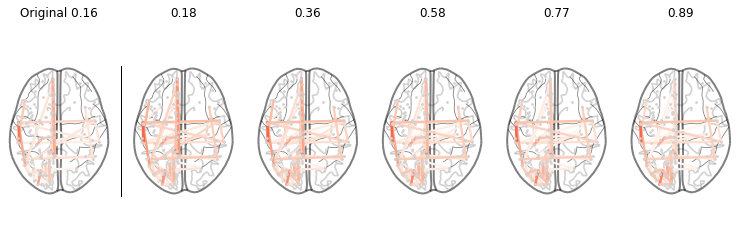

In [634]:
plot_multiple_counterfactuals(5, save_as='../plots/multiple_counterfactuals.png')

In [649]:
def plot_cf_grid(inds, save_as=None):
  n_rows = len(inds)
  n_cols = 2
  fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.8))
  fig.subplots_adjust(hspace=0.3, wspace=0)
  ax = ax.flatten()

  for i in range(n_rows):
    if i != 0:
      ax[i * 2].plot([0, 1.9], [1.2,1.2], color='gray', lw=1, transform=ax[i * 2].transAxes, clip_on=False)

  for i, ind in enumerate(inds):
    ind = int(ind)
    [orig, prob], label, _ = trainer.get_tested_sample(ind)
    orig_fc = trainer.matrix_from_feature(trainer.res, orig)
    percentile = np.nanpercentile(orig_fc, 98.6)
    ax_idx_left = i * 2
    ax_idx_right = i * 2 + 1
    plot_connectome_small(ax[ax_idx_left], orig_fc, title=f'{1 - prob.item():.2f}', th=percentile)
    plot_counterfactual_small(orig, prob, ind, None, ax[ax_idx_right], th=percentile)

  if save_as is not None:
    fig.savefig(save_as, bbox_inches='tight', facecolor='white', dpi=150)

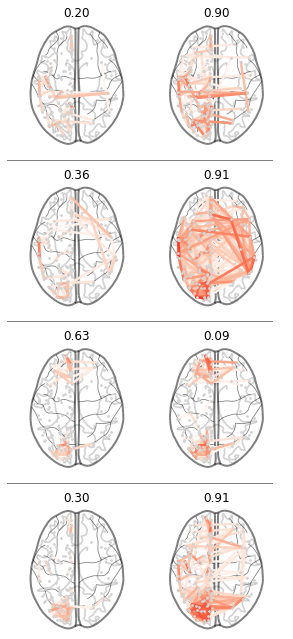

In [650]:
np.random.seed(32)
plot_cf_grid(inds=np.random.randint(0, len(trainer.test_loader.dataset), 4), save_as='../plots/cf_grid.png')

In [651]:
def init_model(type):
  if type == 'mlp':
    additional_args = ['--cond', 'mlp']
  elif type == 'ae':
    additional_args = ['--cond', 'ae']
  elif type == 'svc':
    additional_args = ['--cond', 'svc']
  
  args = Parser().parse_args(args=['--exp', 'final', '--load', '0'] + additional_args)
  exp = args.exp
  final = exp[:5] == 'final'
  args.exp = '_'.join(filter(bool, [args.cond, exp]))
  trainer = get_trainer(args, final)
  trainer.test('test' if final else 'val', save_outputs=args.ind)

  model_path = os.path.join(args.data_dir, 'models')

  if args.cond == 'svc':
      svc_model = joblib.load(os.path.join(model_path, '_'.join(filter(bool, ['svc', exp])) + '.joblib'))

      def model(x):
          return svc_model.predict_proba(x)[:, 1]
  else:
      mlp_model = get_model('MLP', args.res, args.z_dim)
      pretrain = 'pretrain' if args.cond == 'ae' else ''
      model_path_dir = os.path.join(args.data_dir, 'models', '_'.join(filter(bool, ['mlp', pretrain, exp])))
      final_epoch = json.load(open(os.path.join(model_path_dir, 'settings.json')))['training_epochs']
      model_path = os.path.join(model_path_dir, f'model_epoch{final_epoch}.pt')
      state = torch.load(model_path, map_location=torch.device(trainer.device))
      mlp_model.load_state_dict(state, strict=False)
      print('Pretrained weights in ' + model_path + ' loaded.')
      mlp_model = mlp_model.to(trainer.device)

      @torch.inference_mode()
      def model(x):
          if not torch.is_tensor(x):
              x = torch.from_numpy(x)
          mlp_model.eval()
          return torch.sigmoid(mlp_model(x.to(trainer.device))['logits']).cpu().squeeze().numpy()

  return trainer, model

In [652]:
model_types = ['svc', 'mlp', 'ae']
models = []

for model_type in model_types:
  trainer, model = init_model(model_type)
  models.append((trainer, model))

print(models)

Loaded:  ../abide_fc_dataset_scale122/./models/counterfactual_vae_svc_final/model_epoch1000.pt
Version  counterfactual_vae_svc_final


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics:
Criterion: 1.6274e-02	KLD Smooth: 5.9597e+01	KLD: 3.5823e+01	MSE: 1.2757e-02	


/home/marinbenc/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded:  ../abide_fc_dataset_scale122/./models/counterfactual_vae_mlp_final/model_epoch1000.pt
Version  counterfactual_vae_mlp_final


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics:
Criterion: 1.6226e-02	KLD Smooth: 5.9194e+01	KLD: 3.4911e+01	MSE: 1.2718e-02	
Pretrained weights in ../abide_fc_dataset_scale122/models/mlp_final/model_epoch150.pt loaded.
Loaded:  ../abide_fc_dataset_scale122/./models/counterfactual_vae_ae_final/model_epoch1000.pt
Version  counterfactual_vae_ae_final


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics:
Criterion: 1.6264e-02	KLD Smooth: 5.9584e+01	KLD: 3.5359e+01	MSE: 1.2736e-02	
Pretrained weights in ../abide_fc_dataset_scale122/models/mlp_pretrain_final/model_epoch150.pt loaded.
[(<src.trainers.VAETrainer object at 0x7f0ea48f1a60>, <function init_model.<locals>.model at 0x7f0ee01e5820>), (<src.trainers.VAETrainer object at 0x7f0e1681dbe0>, <function init_model.<locals>.model at 0x7f0eec170670>), (<src.trainers.VAETrainer object at 0x7f0f080fdee0>, <function init_model.<locals>.model at 0x7f0eec1499d0>)]


In [665]:
def plot_model_cfs(inds, models, save_as=None):
  cfs_for_model = [[], [], []]
  origs = []
  orig_labels = []
  percentiles = []

  for ind in inds:
    ind = int(ind)
    [orig, prob], label, _ = models[0][0].get_tested_sample(ind)
    orig_labels.append(label)
    orig_fc = models[0][0].matrix_from_feature(models[0][0].res, orig)
    origs.append(orig_fc)
    percentile = np.nanpercentile(orig_fc, 98)
    percentiles.append(percentile)

  print(percentiles)
  for model_idx, (trainer, model) in enumerate(models):
    for ind in inds:
      ind = int(ind)
      cf = get_counterfactual(trainer, ind, model)
      cfs_for_model[model_idx].append(cf)

  fig, ax = plt.subplots(len(inds), 3 + 1, figsize=(13, 13))

  for column in range(4):
    ax[0, column].set_title(['Original', 'MLP', 'AE', 'SVC'][column])

  for row in range(len(inds)):
    plot_connectome_small(ax[row, 0], origs[row], title=f'Original ({"TD" if orig_labels[row].item() > 0.5 else "ASD"})', th=percentiles[row] - 0.1, cmap='Reds')
    ax[row, 0].plot([1.1, 1.1], [0.2, 0.8], color='gray', lw=1, transform=ax[row, 0].transAxes, clip_on=False)

  for column in range(3):
    cfs = cfs_for_model[column]
    row_fcs = [cfs_for_model[column][row] for row in range(len(inds))]
    for row in range(len(inds)):
      cf_fc, cf_prob = cfs[row]
      previous_column_fc = row_fcs[row - 1] if row > 0 else None
      
      plot_connectome_small(ax[row, column + 1], cf_fc, title=f'{model_types[column].upper()}' if row == 0 else None, th=percentiles[row], cmap='Reds')
      
  if save_as is not None:
    fig.savefig(save_as, bbox_inches='tight', facecolor='white', dpi=150)

[0.580132977962494, 0.7573870241642, 0.5249050366878509, 0.5925955748558047]


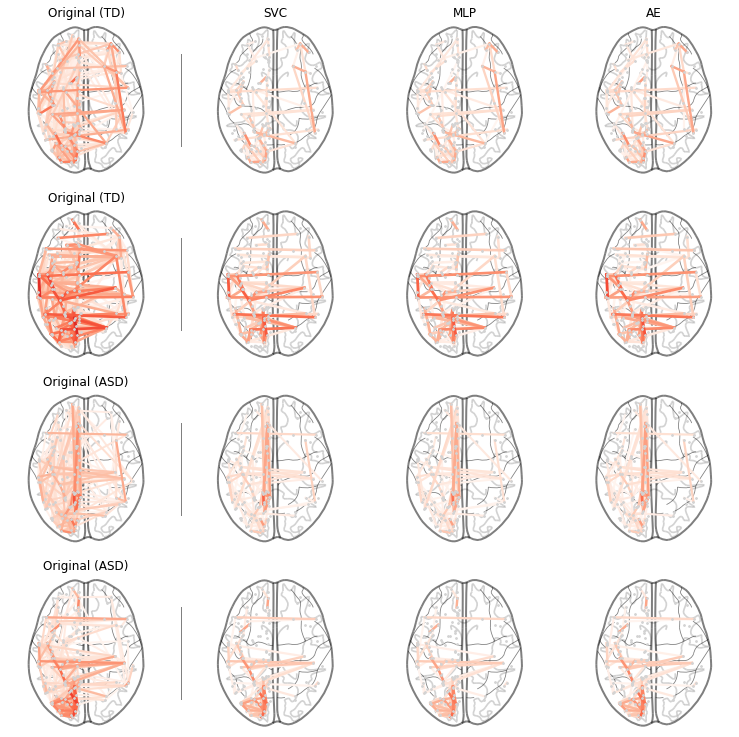

In [668]:
representative_inds = [12, 122, 125, 112]
plot_model_cfs(inds=representative_inds, models=models, save_as='../plots/model_cfs.png')